# Dictionary learning

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import shelve
import pickle
import os.path as op

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn import linear_model, datasets

from nt_toolbox.signal import load_image, imageplot, snr
from nt_toolbox.general import clamp

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TODO: quote the matlab numerical tour

In [7]:
def damage_image(image):
    rho = .7 # percentage of removed pixels
    Omega = np.zeros([img_size, img_size])
    sel = np.random.permutation(img_size**2)
    np.ravel(Omega)[sel[np.arange(int(rho*img_size**2))]] = 1

    Phi = lambda f, Omega: f*(1-Omega)

    damaged_image = Phi(image, Omega)
    return damaged_image

def random_dictionary(image, width, n_atoms):
    '''
    Takes an image as input and returns a dictionary
    of shape (width*width, n_atoms)
    '''
    assert image.shape[0] == image.shape[1]
    n0 = image.shape[0]
    
    # Random sampling of coordinates of the top left corner or the patches
    x = (np.random.random((1,1,n_atoms))*(n0-width)).astype(int)
    y = (np.random.random((1,1,n_atoms))*(n0-width)).astype(int)
    
    # Extract patches
    [dY,dX] = np.meshgrid(range(width), range(width))
    dX = np.tile(dX, (n_atoms,1,1)).transpose((1,2,0))
    dY = np.tile(dY, (n_atoms,1,1)).transpose((1,2,0))
    Xp = np.tile(x, (width,width,1)) + dX
    Yp = dY + np.tile(y, (width,width,1))
    D = image.flatten()[Yp+Xp*n0]
    D = D.reshape((width*width,n_atoms)) # Reshape from (w,w,q) to (w*w,q)
    return D

def center(D):
    '''
    Takes a Dictionary of shape (signal_size, n_atoms) and
    substract the signal-wise mean.
    '''
    assert len(D.shape) == 2
    D -= D.mean(axis=0)
    return D

def scale(D):
    ''' Scale the dictionary atoms to unit norm '''
    assert len(D.shape) == 2
    norm = np.tile(np.linalg.norm(D, axis=0), (D.shape[0],1))
    D = np.divide(D, norm)
    return D

def high_energy_random_dictionary(image, width, n_atoms):
    '''
    Initialize a random dictionary with high energy centered and 
    normalized atoms  of size (width*width, n_atoms)
    '''
    m = 20*n_atoms
    q = 3*m
    D = random_dictionary(image, width, q)
    D = center(D)
    # Keep patches with highest energy
    energies = np.sum(D**2, axis=0)
    Indexes = np.argsort(energies)[::-1]
    D = D[:,Indexes[:m]]
    # Select a random subset of these patches
    sel = np.random.permutation(range(m))[:n_atoms]
    D = D[:,sel]
    D = scale(D)
    return D

def plot_dictionary(D):
    ''' Plot a dictionary of shape (width*width, n_atoms) '''
    # Check that D.shape == (width*width, n_atoms)
    assert len(D.shape) == 2
    assert int(np.sqrt(D.shape[0]))**2 == D.shape[0]
    (signal_size, n_atoms) = D.shape
    width = int(np.sqrt(D.shape[0]))
    D = D.reshape((width,width,n_atoms))
    n = int(np.ceil(np.sqrt(n_atoms))) # Size of the plot square in number of atoms

    # Pad the atoms
    pad_size = 1
    missing_atoms = n ** 2 - n_atoms

    padding = (((pad_size, pad_size), (pad_size, pad_size),
                (0, missing_atoms)))
    D = np.pad(D, padding, mode='constant', constant_values=1)
    padded_width = width + 2*pad_size
    D = D.reshape(padded_width,padded_width,n,n)
    D = D.transpose(2,0,3,1) # Needed for the reshape
    big_image_size = n*padded_width
    D = D.reshape(big_image_size, big_image_size)
    imageplot(D)

def ProjX(X,k):
    ''' Sparsity projection, keeps the k largest coefficients '''
    X = X * (abs(X) >= np.sort(abs(X), axis=0)[-k,:])
    return X


def ProjC(D):
    ''' Dictionary projection, scales the atoms '''
    D = scale(D)
    return D

def sparse_code_pgd(Y, D, X, sparsity=4, n_iter=100):
    '''
    Sparse code data Y using dictionary D using a forward backward iterative scheme.
    This is a non-smooth and non-convex minimization, that can be shown to be NP-hard.
    A heuristic to solve this method is to compute a stationary point of the energy
    using the Foward-Backward iterative scheme (projected gradient descent).
    '''
    gamma = 1/np.linalg.norm(np.dot(D,D.T)) # TODO: Improve gamma ? (compare with nt)
    for i in range(n_iter):
        R = np.dot(D, X) - Y
        X = ProjX(X - gamma * np.dot(D.T, R), sparsity)
    return X

def sparse_code_lasso(Y, D, model):
    ''' Sparse code data Y using dictionary D using lasso linear regression '''
    X = lasso.fit(D, Y).coef_.T
    return X

def dictionary_update_pgd(Y, D, X, n_iter=50):
    tau = 1/np.linalg.norm(np.dot(X, X.T)) # TODO: Improve tau ? (compare with nt)
    for i in range(n_iter):
        R = np.dot(D, X) - Y
        D = ProjC(D - tau * np.dot(R, X.T))
    return D

def dictionary_update_omf(D, A, B):
    '''
    Algorithm 2 from "Online Learning for Matrix Factorization and Sparse Coding
    Update the dictionary column by column.
    Denoting k the number of atoms in the dictionary and m the size of the signal, we have:
    
    Args:
        D: dictionary of size (m,k)
        A: Matrix of size (k,k)
        B: Matrix of size (m,k)
    Returns:
        D: Updated dictionary of size (m,k)
    '''
    (m,k) = D.shape
    assert A.shape == (k,k)
    assert B.shape == (m,k)
    
    for j in range(k):        
        uj = (B[:,j]-np.dot(D,A[:,j])) + D[:,j]
        if A[j,j] != 0:
            uj /= A[j,j]
        else:
            # TODO: What to do when A[j,j] is 0 ?
            pass
        D[:,j] = 1/max(np.linalg.norm(uj),1)*uj
    return D

def reconstruction_error(Y, D, X):
    error = np.linalg.norm(Y_test - np.dot(D, X))**2
    return error

## Image and variables

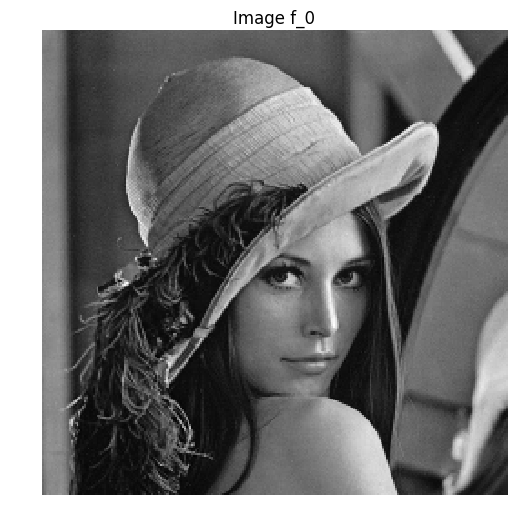

In [8]:
img_size = 256
filename = 'image.jpg'
filename = 'barb_crop.png'
filename = 'lena.bmp'
f0 = load_image(filename, img_size)

plt.figure(figsize = (6,6))
imageplot(f0, 'Image f_0')

In [37]:
width = 2
signal_size = width*width
n_atoms = 2*signal_size
n_samples = 20*n_atoms
k = 4 # Desired sparsity

In [51]:
Y_test, D0, X0 = datasets.make_sparse_coded_signal(n_samples, n_atoms, signal_size, k, random_state=0)
D = np.random.random(D0.shape)

In [39]:
omp = linear_model.OrthogonalMatchingPursuit(k, fit_intercept=False)

In [40]:
D0 = high_energy_random_dictionary(f0, width, n_atoms)
Y_test = random_dictionary(f0, width, n_samples)
Y_test = center(Y_test) # TODO: Center because the dictionary is centered and no intercept

# Numerical tour approach

In [52]:
n_iter_learning = 100
n_iter_dico = 50
n_iter_coef = 100
E = np.zeros(2*n_iter_learning)
X = np.zeros((n_atoms, n_samples))
D = D0
for i in tqdm(range(n_iter_learning)):
    # --- coefficient update ----
    X = sparse_code_pgd(Y_test, D, X, sparsity=k, n_iter=n_iter_coef)
    E[2*i] = reconstruction_error(Y_test, D, X)
    # --- dictionary update ----
    D = dictionary_update_pgd(Y_test, D, X, n_iter=n_iter_dico)
    E[2*i+1] = reconstruction_error(Y_test, D, X)

100%|██████████| 100/100 [00:01<00:00, 75.85it/s]


Plot

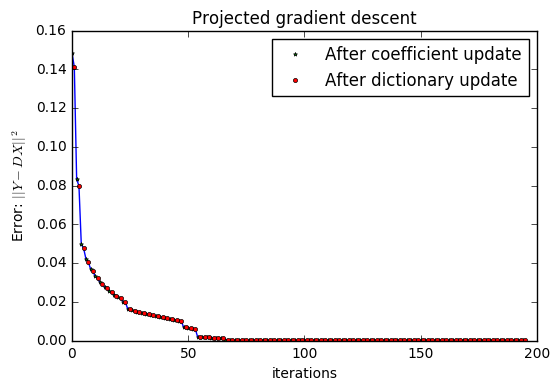

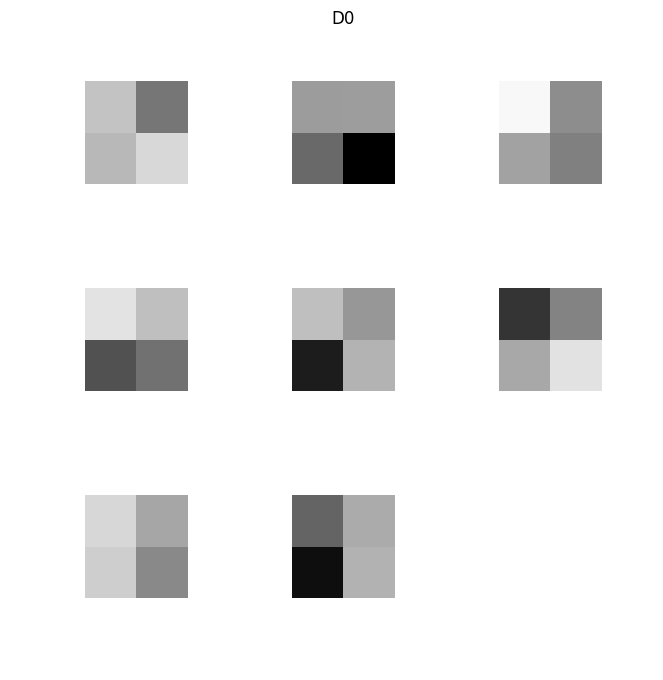

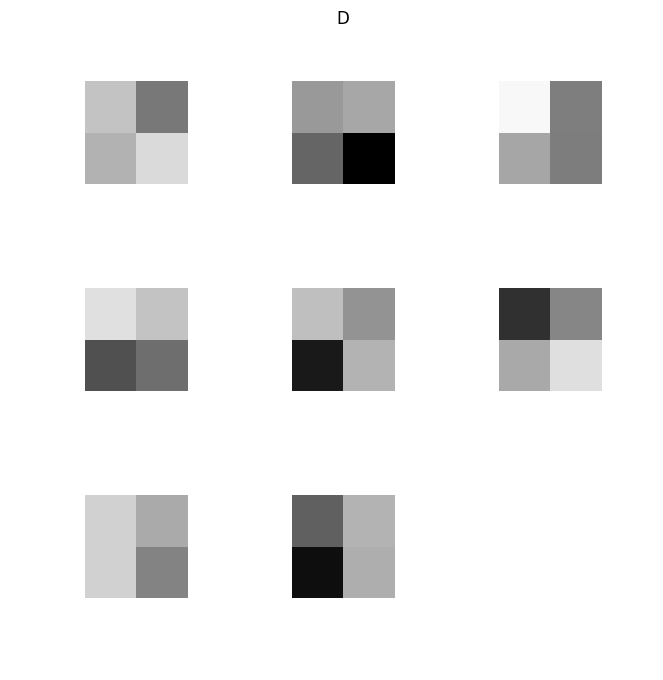

2.8058179348748329e-08

In [49]:
# Remove first points (burn in)
start = 4
assert start%2==0
E_plot = E[start:]

plt.plot(range(E_plot.shape[0]), E_plot)
index_coef = list(range(0, E_plot.shape[0], 2))
index_dico = list(range(1, E_plot.shape[0], 2))
plt.plot(index_coef, E_plot[index_coef], '*', markersize=3, label='After coefficient update')
plt.plot(index_dico, E_plot[index_dico], 'o', markersize=3, label='After dictionary update')
plt.legend(numpoints=1)
plt.xlabel('iterations')
plt.ylabel('Error: $||Y-DX||^2$')
plt.title('Projected gradient descent')
plt.savefig('images/projected_gradient_descent.png')
plt.show()

plt.figure(figsize=(8,12))
plot_dictionary(D0)
plt.title('D0')
plt.show()
plt.figure(figsize=(8,12))
plot_dictionary(D)
plt.title('D')
plt.show()

min(E)

# Online dictionary learning
From "Online Learning for Matrix Factorization and Sparse Coding"  
LARS-Lasso from LEAST ANGLE REGRESSION, Efron et al http://statweb.stanford.edu/~tibs/ftp/lars.pdf

In [ ]:
n_iter = 5*n_samples
test_interval = 1000
lambd = 0.01 # L1 penalty coefficient for sparse coding
lasso = linear_model.Lasso(lambd, fit_intercept=False) # TODO: use lars instead of lasso

D = D0
A = np.zeros((n_atoms,n_atoms))
B = np.zeros((signal_size,n_atoms))

sparsity = []
E = []
Y_test = random_dictionary(f0, width, 20*n_atoms)
X = np.zeros((n_atoms, n_samples))

In [ ]:
for i in tqdm(range(n_iter)):
    # Draw 1 random patch y and get its sparse coding
    #y = random_dictionary(f0, width, n_atoms=1)
    y = Y_test[:,np.random.randint(Y_test.shape[1])].reshape((signal_size,1))
    x = lasso.fit(D, y).coef_.reshape((n_atoms,1))
    A += np.dot(x,x.T)
    B += np.dot(y,x.T)
    D = dictionary_update_omf(D, A, B)
    D = ProjC(D)
    sparsity.append(np.mean(np.sum(x!=0, axis=0)))
    
    if i%test_interval == 0:
        # Evaluation:
        X = sparse_code_pgd(Y_test, D, X, sparsity=4, n_iter=100)
        E.append(reconstruction_error(Y_test, D, X))
        #sparsity.append(np.mean(np.sum(X!=0, axis=0)))

In [ ]:
plt.plot(range(0, n_iter, test_interval), E)
plt.title('Reconstruction error on the test set')
plt.show()
#plt.savefig('omf_2400000_iter.png')
plt.figure(figsize=(8,12))
plot_dictionary(D0)
plt.title('D0')
plt.show()
plt.figure(figsize=(8,12))
plot_dictionary(D)
plt.title('D')
plt.show()
plt.plot(sparsity)

Save variables

In [ ]:
filename = op.join('vars','omf_iter.out')
with shelve.open(filename,'n') as shelf: # 'n' for new
    for key in dir():
        try:
            shelf[key] = globals()[key]
        except (TypeError, pickle.PicklingError, AttributeError):
            #
            # __builtins__, my_shelf, and imported modules can not be shelved.
            #
            print('ERROR shelving: {0}'.format(key))